## PCA with PyKrev

* In this guide we will cover how to perform PCA on your FT-MS data using the sklearn (sci-kit learn) library and PyKrev.  PCA is a dimensionality reduction technique which projects your data onto a smaller subset of axis (known as principal components) whilst preserving maximum variance.
In this guide we will cover: 
 * Data Preparation 
 * Scree and variance plots
 * 2D PCA plots
 * Loading plots

In [1]:
from sklearn.decomposition import PCA #if you do not already have the library installed run 'pip install scikit-learn'
import pykrev as pk
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
np.random.seed(87) ## seed the RNG (for reproducible figures)

* First we need to load in our dataset. In this example we are going to load in a batch aligned dataset. ```read_batch_formularity``` can then compute an ordination matrix directly on the data.
  * The dataset was taken from [Kew, Will, et al. (2018)](https://pubs.acs.org/doi/10.1021/acs.analchem.8b01446) and consists of four whisky samples (samples A - D) analysed using ESI mode FT-MS with formula assignment rules of O>0, N<2, S<=2, P<1.

In [3]:
fdata, fordination = pk.read_batch_formularity('example_data/batch_formularity.csv', impute_value = 0)
nsample, nformula = fordination.shape #the ordination matrix has samples in rows and formula in columns

Warning, duplicate formula assignments detected. Ordination matrix will report values for first formula it encounters.


* We should transpose the ordination matrix, so that the samples names are the column headers and the formula the rows in order to compute relative intensity. We can then compute relative intensity (sum normalised) calculations on the columns of this matrix using ```relative_intensity```. 
  * An important caveat: sum-normalised relative intensity calculations on FT-MS data is limited by the fact that FT-MS is not a quantitative technique, and the peak intensities of the formula in a sample are indicative of ionisation efficiency as well as the relative abundance of that formula. By making relative intensity calculations we are effectively treating the data as quantitiative and biasing our analysis against formula that do not efficiently ionize.  
  * If you would like to avoid making relative intensity calculations on your data, you can process the ordination matrix as a binary matrix, which indicates the presence or absence of a formula (1 or 0) but does not contain information about its abundance. I've provided a function ```binary_matrix``` that will convert an ordination matrix into this format. You can perform PCA on a binary matrix, but [it's not without it's own caveats](https://stats.stackexchange.com/questions/16331/doing-principal-component-analysis-or-factor-analysis-on-binary-data). 
  * In this example we will continue to use relative intensities. 

In [4]:
rordination = pk.relative_intensity(fordination.T)

In [5]:
def binary_matrix(ordination):
    """ This function converts an ordination matrix into a binary matrix."""
    bordination = ordination.copy()
    for idx in bordination.index:
        bordination.loc[idx][bordination.loc[idx] > 0] = 1
    return bordination
bordination = binary_matrix(fordination) # no need to transpose!

* Make sure to re-transpose the data back (so that sample names are rows and formula are column headers) prior to performing PCA.
  * If you used the ```binary_matrix``` function the data is already in the right format.

In [6]:
pordination = rordination.T
assert pordination.shape == (nsample,nformula)

* Now we are ready to perform PCA using the [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) library. PCA is performed by computing the eigenvectors of the covariance matrix of our dataset. The eigenvalues of each of these vectors explain how much of the variance was captured by their eigenvector. The PCA class within the sklearn library allows you to modify the method used to perform the eigendecomposition and change the number of components to keep. We are going to use the default parameters in which all principal components are kept.

In [7]:
pca = PCA() #instance of the PCA class, here we can define parameters about the PCA 
pca.fit(pordination) #fit the PCA intialised with default parameters to our data
pca_result = pca.transform(pordination) # transform our data with the fitted model

* One way to visualise the variance explained by your principal coordinates is with a scree plot and a variance plot. You can use the ```scree_plot``` and ```variance_plot``` functions i've defined below to do this. 

In [8]:
def scree_plot(pca_instance, **kwargs):
    """ This function creates a scree plot on the results of the sklearn implementation of PCA."""
    varExplained = pca_instance.explained_variance_ 
    componentN  = np.arange(1,len(varExplained)+1)
    plt.bar(componentN,varExplained, **kwargs)
    plt.xticks(componentN)
    plt.xlabel('Principal Component')
    plt.ylabel('Eigenvalue')
    return plt.gcf(), plt.gca()

In [9]:
def variance_plot(pca_instance, **kwargs):
    """ This function creates a variance plot on the results of the sklearn implementation of PCA."""
    varExplained = pca_instance.explained_variance_ratio_
    cumVarExplained = np.cumsum(pca_instance.explained_variance_ratio_)
    componentN  = np.arange(1,len(varExplained)+1)
    plt.scatter(componentN,varExplained)
    plt.plot(componentN,varExplained, linestyle = '-', **kwargs)
    plt.scatter(componentN,cumVarExplained)
    plt.plot(componentN,cumVarExplained, linestyle = '--',**kwargs)
    plt.xticks(componentN)
    plt.xlabel('Principal Component')
    plt.ylabel('Variance explained ')
    plt.legend(['Proportion','Cumulative'])
    return plt.gcf(), plt.gca()   

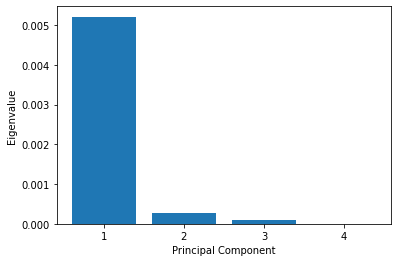

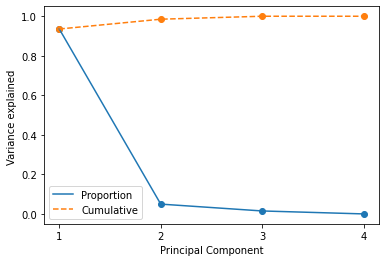

In [10]:
plt.figure()
fig, ax = scree_plot(pca)
plt.figure()
fig, ax = variance_plot(pca)

* So the first principal component explains ~94% of variation in the dataset, and the second ~5%. Let's plot the data, to do this we will use the ```pca_plot``` function which is defined below.

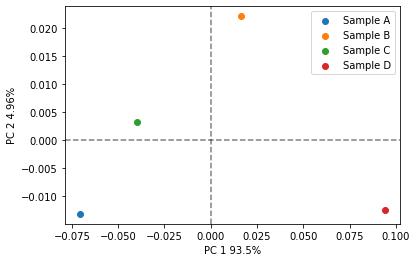

In [11]:
def pca_plot(pca_result, pca_instance, group_names, text_offset = 0.002, text = False, **kwargs):
    """ This function creates a 2D PCA plot on the results of the sklearn implementation of PCA."""
    assert len(group_names)==len(pca_result[:,1])
    varExplained = pca_instance.explained_variance_ratio_
    for i in range(0,len(group_names)):
        # scatter points with default pyplot colour scheme
        plt.scatter(pca_result[i,0],pca_result[i,1], **kwargs)
        # add text labels to scatter points 
        if text == True:
             plt.text(pca_result[i,0] + text_offset,pca_result[i,1], group_names[i])
    #label axes
    plt.xlabel(f"PC 1 {str(varExplained[0]*100)[:4]}%")
    plt.ylabel(f"PC 2 {str(varExplained[1]*100)[:4]}%")
    plt.legend(group_names)
    ## add axis lines (like abline in r)
    plt.axhline(0, color='k', linestyle = '--', alpha = 0.5)
    plt.axvline(0, color='k', linestyle = '--', alpha = 0.5)

    return plt.gcf(), plt.gca() 

fig, ax = pca_plot(pca_result = pca_result, pca_instance = pca, text = False,
         group_names = ['Sample A', 'Sample B', 'Sample C', 'Sample D'])

* The PCA plot is useful to visualise the separation between our samples, but how do the features of our dataset (in this case the molecular formula) contribute to this separation? To visualise this we will use loading plots. 
 * First we need to extract the loadings and label them by their corresponding molecular formula. 

In [12]:
formula = list(fordination.columns) #extract the column headers from the ordination matrix 
loadings = pca.components_.T #extract the loadings of the formula 
loadingDF= pd.DataFrame(loadings,formula) #this constructs a dataframe with the formula as rows and the loadings for the four principal components as columns
loadingDF.head()

,0,1,2,3
C25H32O14,-0.000494,0.000781,0.009780,-0.880367
C6H8O5,-0.026645,-0.029505,0.018159,-0.362122
C13H22O10,0.002567,0.011335,0.021789,0.257237
C23H18O6S1,-0.000628,0.000993,0.012425,0.000545
C12H18O10,-0.016757,-0.037426,-0.095240,-0.000978


* Now we have to visualise our loadings. There are many ways we can do this and it's a great place to get creative. Functions in the formula, plotting and diversity packages in PyKrev can help. Below I have defined functions to create : 

  * a loading plot that recreates a mass spectrum with the contribution of masses to the PCs using ```mass_loading_plot```.
  * a loading plot that shows the sum contribution of compound classes to the PCs using ```cclass_loading_plot```.
  * a loading plot that shows the sum contribution of oxygen classes to the PCs using ```oxygen_loading_plot```.


In [13]:
def mass_loading_plot(loadingDF):
    """This function takes a loading dataframe and plots the loadings of the first 2 PCs against mass"""
    formula = list(loadingDF.index)
    pk.mass_spectrum(formula_list=formula, peak_intensities= loadingDF.iloc[:,0],method = 'average', normalise= False, color = 'b')
    pk.mass_spectrum(formula_list=formula, peak_intensities= loadingDF.iloc[:,1],method = 'average', normalise= False, color = 'orange')
    plt.ylabel('Loading')
    plt.legend(['PC1','PC2'])
    
    return plt.gcf(), plt.gca()

In [14]:
def cclass_loading_plot(loadingDF):
    """This function takes a loading dataframe and plots a bar chart of compound class 
        with the sum loadings of the first 2 PCs """
    formula = list(loadingDF.index)
    #perform compound class assignment using the formularity assignment rules
    assignments, counts = pk.compound_class(formula,method = 'FORM')
    #make a dictionary to store the sum of the loading values per compound class inside 
    # for PC1
    compoundPC1 = dict()
    # initialise dictionary with 0 values
    for i in range(0,len(loadingDF.index)):
        compoundPC1[assignments[i]] = 0 
    # sum the assignment values 
    for i in range(0,len(loadingDF.index)):
        compoundPC1[assignments[i]] += loadingDF.iloc[i,0]
    # sort the compound classes dictionaries alphabetically (ordered dicts possible in >Python 3.7)
    sortedPC1 = dict()
    for s in sorted(compoundPC1):
        sortedPC1[s] = compoundPC1[s]
    # for PC2 
    compoundPC2 = dict()
    for i in range(0,len(loadingDF.index)):
        compoundPC2[assignments[i]] = 0 
    for i in range(0,len(loadingDF.index)):
        compoundPC2[assignments[i]] += loadingDF.iloc[i,1]
    sortedPC2 = dict()
    for s in sorted(compoundPC2):
        sortedPC2[s] = compoundPC2[s]
    # extract the values to plot on the y axis
    y1 = np.array(list(sortedPC1.values()))
    y2 = np.array(list(sortedPC2.values()))
    # create a number line for the x axis, 
    #adequately spaced to allow side by side bars for PC1 and PC2
    xrange = np.arange(0,len(y1)*3,3)
    plt.bar(xrange,y1)
    plt.bar(xrange+.8,y2)
    plt.legend(['PC1','PC2'])
    plt.axhline(0, color='k', linestyle = '--', alpha = 0.5)
    #Include xticks 
    plt.xticks(xrange,list(sortedPC1.keys()), rotation= 'vertical')
    plt.xlabel('Compound class')
    plt.ylabel('Sum loadings')
    # return the range of the x-axis (so we can set custom x ticks if needed)
    return plt.gcf(), plt.gca(), xrange

In [15]:
def oxygen_loading_plot(loadingDF):
    """This function takes a loading dataframe and plots a bar chart of oxygen class 
        with the sum loadings of the first 2 PCs """
    formula = list(loadingDF.index)
    #perform oxygen class assignment using element counts 
    oxygen_counts = [o['O'] for o in pk.element_counts(formula)]
    #make a dictionary to store the sum of the loading values per compound class inside 
    # for PC1
    oxygenPC1 = dict()
    # initialise dictionary with 0 values
    for i in range(0,len(loadingDF.index)):
        oxygenPC1[oxygen_counts[i]] = 0 
    # sum the assignment values 
    for i in range(0,len(loadingDF.index)):
        oxygenPC1[oxygen_counts[i]] += loadingDF.iloc[i,0]
    # sort the oxygen class dictionaries numerically (ordered dicts possible in >Python 3.7)
    sortedPC1 = dict()
    for s in sorted(oxygenPC1):
        sortedPC1[s] = oxygenPC1[s]
    # for PC2 
    oxygenPC2 = dict()
    for i in range(0,len(loadingDF.index)):
        oxygenPC2[oxygen_counts[i]] = 0 
    for i in range(0,len(loadingDF.index)):
        oxygenPC2[oxygen_counts[i]] += loadingDF.iloc[i,1]
    sortedPC2 = dict()
    for s in sorted(oxygenPC2):
        sortedPC2[s] = oxygenPC2[s]
    # extract the values to plot on the y axis
    y1 = np.array(list(sortedPC1.values()))
    y2 = np.array(list(sortedPC2.values()))
    # create a number line for the x axis, 
    #adequately spaced to allow side by side bars for PC1 and PC2
    xrange = np.arange(0,len(y1)*3,3)
    plt.bar(xrange,y1)
    plt.bar(xrange+.8,y2)
    plt.legend(['PC1','PC2'])
    plt.axhline(0, color='k', linestyle = '--', alpha = 0.5)
    #Include xticks 
    plt.xticks(xrange,list(sortedPC1.keys()), rotation= 'vertical')
    plt.xlabel('Oxygen class')
    plt.ylabel('Sum loadings')
    # return the range of the x-axis (so we can set custom x ticks if needed)
    return plt.gcf(), plt.gca(), xrange

* In each case I like to plot the positions of the samples on the first two principal components next to the loading plot to make analysing the plots easier. This is possible using ```plt.subplots``` to create panelled figures. 


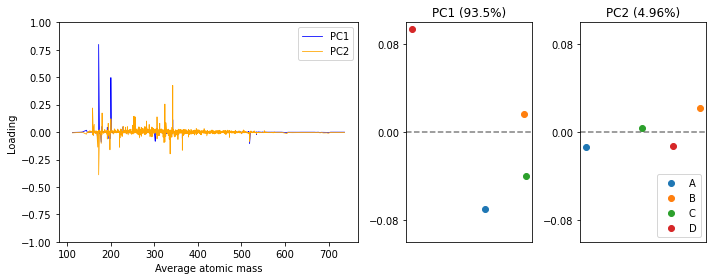

In [16]:
## MASS LOADINGS 
varExplained = pca.explained_variance_ratio_ #variance explained in your PCA results
group_names = ['A','B','C','D'] # sample names
plt.figure(figsize=(10, 4)) # create the overall figure
plt.subplot(1,4,(1,2)) #take the first two panels of the subplot for the loading plot
mass_loading_plot(loadingDF)
plt.ylim(-1,1) # centre the y axis
plt.subplot(1,4,3) #take the third panel for the PC1 plot
for i in range(0,4):
    ## the np.random function shudders the x coordinates of the points, which is necessary to prevent overlap
    plt.scatter(np.random.uniform(-.1,.1, 1),pca_result[i,0])
plt.title(f'PC1 ({str(varExplained[0]*100)[:4]}%)') #include the % variance explained in the 
plt.ylim(-.1,.1)
plt.xticks([])
plt.yticks([-.08,0,.08])
plt.axhline(0, color='k', linestyle = '--', alpha = 0.5)
plt.subplot(1,4,4) #take the final panel for the PC2 plot
for i in range(0,4):
    plt.scatter(np.random.uniform(-.1,.1, 1),pca_result[i,1]) 
plt.title(f'PC2 ({str(varExplained[1]*100)[:4]}%)')
plt.ylim(-.1,.1)
plt.xticks([])
plt.yticks([-.08,0,.08])
plt.legend(group_names, loc = 'lower right')
plt.axhline(0, color='k', linestyle = '--', alpha = 0.5)
plt.tight_layout()
plt.show()

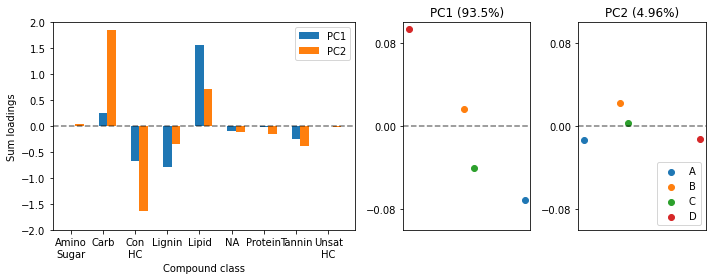

In [17]:
## COMPOUND CLASS LOADINGS 
varExplained = pca.explained_variance_ratio_ #variance explained in your PCA results
group_names = ['A','B','C','D']
custom_classes = ['Amino\nSugar','Carb','Con\nHC','Lignin','Lipid','NA','Protein','Tannin','Unsat\nHC']
plt.figure(figsize=(10, 4)) # create the overall figure
plt.subplot(1,4,(1,2)) #take two panels of the subplot for the loading plot
fig, ax, xrange = cclass_loading_plot(loadingDF)
plt.ylim(-2,2) #centre the y axis
## Important!! If you are copying this code, first check the order of your xticks before manually setting them
plt.xticks(xrange,custom_classes, rotation = 'horizontal') #Set custom xticks to save space
plt.subplot(1,4,3) #take one panel for the PC1 plot
for i in range(0,4):
    plt.scatter(np.random.uniform(-.1,.1, 1),pca_result[i,0]) #shudder the points to avoid overlap 
plt.title(f'PC1 ({str(varExplained[0]*100)[:4]}%)') #include the % variance explained in the 
plt.ylim(-.1,.1)
plt.xticks([])
plt.yticks([-.08,0,.08])
plt.axhline(0, color='k', linestyle = '--', alpha = 0.5)
plt.subplot(1,4,4) #take the final panel for the PC2 plot
for i in range(0,4):
    plt.scatter(np.random.uniform(-.1,.1, 1),pca_result[i,1]) 
plt.title(f'PC2 ({str(varExplained[1]*100)[:4]}%)') #include the % variance explained in the 
plt.ylim(-.1,.1)
plt.xticks([])
plt.yticks([-.08,0,.08])
plt.legend(group_names, loc = 'lower right')
plt.axhline(0, color='k', linestyle = '--', alpha = 0.5)
plt.tight_layout()
plt.show()

In [ ]:
## OXYGEN CLASS LOADINGS 
varExplained = pca.explained_variance_ratio_ #variance explained in your PCA results
group_names = ['A','B','C','D']
plt.figure(figsize=(10, 4)) # create the overall figure
plt.subplot(1,4,(1,2)) #take two panels of the subplot for the loading plot
oxygen_loading_plot(loadingDF)
plt.ylim(-2,2) #centre the y axis
plt.subplot(1,4,3) #take one panel for the PC1 plot
for i in range(0,4):
    plt.scatter(np.random.uniform(-.1,.1, 1),pca_result[i,0]) #shudder the points to avoid overlap 
plt.title(f'PC1 ({str(varExplained[0]*100)[:4]}%)') #include the % variance explained in the 
plt.ylim(-.1,.1)
plt.xticks([])
plt.yticks([-.08,0,.08])
plt.axhline(0, color='k', linestyle = '--', alpha = 0.5)
plt.subplot(1,4,4) #take the final panel for the PC2 plot
for i in range(0,4):
    plt.scatter(np.random.uniform(-.1,.1, 1),pca_result[i,1]) 
plt.title(f'PC2 ({str(varExplained[1]*100)[:4]}%)') #include the % variance explained in the 
plt.ylim(-.1,.1)
plt.xticks([])
plt.yticks([-.08,0,.08])
plt.legend(group_names, loc = 'lower right')
plt.axhline(0, color='k', linestyle = '--', alpha = 0.5)
plt.tight_layout()
plt.show()

* Analysing the above graphics we can see that in the first principal component, that accounts for ~95% of variation in the dataset, both whisky sample B and D have positive scores, although sample D has a notably higher score. From the loading plots we can say that these samples are  correlated  with two masses, one at ~ 180 Da and one ~ 200 Da, and with formula assigned to the lipid compound class, and with formula that have < 5 oxygen atoms. Whisky sample A and C have negative scores on PC1, and are correlated with two masses ~300 Da and ~500 Da, formula assigned to condensed hydrocarbon and lignin compound classes, and formula with oxygen counts > 15.

**That's the end of the guide.** Hopefully you are now more comfortable using sklearn and PyKrev to perform dimensionality reduction on your FT-MS data and interpret the results. One of the main advantages of doing your data analysis in Python is being able to use the powerful machine learning libraries Python has to offer. sklearn has many capabilities beyond PCA - ... discriminant analysis, k-means clustering, neural networks, random forest classifiers and  support vector machines to name just a few -  that will enable you to ask new and interesting questions with your data. [ You can learn more about them here.](https://scikit-learn.org/stable/)
  * Contact : ezra.kitson@ed.ac.uk
  * Last Updated: 12/01/2021